This repository contains functions for generating the prediction skill across East Africa on the Administrative Level 1 Level and computing a pixelwise evaluation of prediction skill using EDM across Africa for a given environmental variable

- To do: 
    - look at sensitivity of ED on spatial scale and then adjust pixelwise analysis so that it is using the optimal ED for each pixel
    - what to do about gaps in time series 

In [3]:
from pyEDM import *
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona
import rasterio.mask
from descartes import PolygonPatch
from rasterio.plot import show
from tqdm import tqdm
import datetime

In [4]:
croplands_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Croplands/'
grasslands_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Grasslands/'
savannas_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Savannas/'
cropnatveg_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_CropNatVeg/'
EA_TS_DIR = '/home/rgreen/DroughtEDM/Data/EA_TS/Final/'

Africa_simplex = '/home/rgreen/DroughtEDM/Data/Africa_simplex/' #out directory

Admin_boundaries = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/AdminBoundaries/'

In [5]:
precip_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Resampled/' 
temp_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRTS/Dekads/'
ndvi_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Resampled/' 
sm_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/FLDAS_SM/Dekads/' 
pet_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Hobbins_ET/Resampled/'
lst_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Resampled/'

In [6]:
#anomaly out directories
anomaly_ndvi = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly/'
anomaly_precip = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly/'
anomaly_temp = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRTS/Anomaly/'
anomaly_sm = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/FLDAS_SM/Anomaly/'
anomaly_pet = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Hobbins_ET/Anomaly/'
anomaly_lst = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly/'

In [9]:
ea_adminbds = Admin_boundaries + 'gadm36_EastAfrica.shp'
ea_bndry = gpd.read_file(ea_adminbds)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
Africa_basemap = world[world['continent'] == 'Africa']
EA_countries = ['Burundi', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Rwanda', 'Sudan', 'S. Sudan', 'Somalia', 'Somaliland', 'South Sudan', 'Tanzania', 'Uganda']
EastAfrica_basemap = world[world['name'].isin(EA_countries)]
EastAfrica_basemap.to_file(Admin_boundaries + 'EastAfrica_countries.shp')

In [10]:
Tanzania = EastAfrica_basemap[EastAfrica_basemap.name == 'Tanzania']
Kenya = EastAfrica_basemap[EastAfrica_basemap.name == 'Kenya']
Sudan = EastAfrica_basemap[EastAfrica_basemap.name == 'Sudan']
Burundi = EastAfrica_basemap[EastAfrica_basemap.name == 'Burundi']
Eritrea = EastAfrica_basemap[EastAfrica_basemap.name == 'Eritrea']
Ethiopia = EastAfrica_basemap[EastAfrica_basemap.name == 'Ethiopia']
Djibouti = EastAfrica_basemap[EastAfrica_basemap.name == 'Djibouti']
Uganda = EastAfrica_basemap[EastAfrica_basemap.name == 'Uganda']
Rwanda = EastAfrica_basemap[EastAfrica_basemap.name == 'Rwanda']
SSudan = EastAfrica_basemap[EastAfrica_basemap.name == 'S. Sudan']
Somalia = EastAfrica_basemap[EastAfrica_basemap.name.isin(['Somalia', 'Somaliland'])]

Tanzania.to_file(Admin_boundaries + 'Tanzania.shp')
Kenya.to_file(Admin_boundaries + 'Kenya.shp')
Sudan.to_file(Admin_boundaries + 'Sudan.shp')
Burundi.to_file(Admin_boundaries + 'Burundi.shp')
Eritrea.to_file(Admin_boundaries + 'Eritrea.shp')
Ethiopia.to_file(Admin_boundaries + 'Ethiopia.shp')
Djibouti.to_file(Admin_boundaries + 'Djibouti.shp')
Uganda.to_file(Admin_boundaries + 'Uganda.shp')
Rwanda.to_file(Admin_boundaries + 'Rwanda.shp')
SSudan.to_file(Admin_boundaries + 'SSudan.shp')
Somalia.to_file(Admin_boundaries + 'Somalia.shp')

In [11]:
begin = pd.datetime(2002,7,1)
end = pd.datetime(2016,12,31)
dtrange = pd.date_range(begin, end)
days = list(range(0,5298)) #length of dtrange
daysDF = pd.DataFrame({'Days': days}, index=dtrange)
d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
dekads = daysDF.groupby(dekaddates).mean()
dekads = dekads.index

## 1. Prediction Skill Across Admin Zones East Africa

In [17]:
def single_simplex_error(in_dir, var1, var2, train, test, ed, pi, col):
    '''
    This function computes the simplex prediction skill for a given land cover, environmental variable, embedding dimensions and prediction interval

    The result is a dataframe of error values and the filename describing each area and land cover
    Args:
    - in_dir: input directory 
    - file: filename (string)
    - var1: training variable (string)
    - var2: testing variable (string) (often training and testing the same)
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp)  
    - param: error parameter (MAE, RMSE, rho)
    '''
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains('.csv')
    files = files[tifs]
    
    #param_range = list(itertools.product(list(range(1,19)), repeat = 2))[:180]
    #cut off at 180 because we are only interested in the first 10 embedding dimensions but 18 dekads forward 
    #six_mo_error = collections.OrderedDict()
    output = []
    
    for filename in files:
        
        data = pd.read_csv(in_dir+filename, usecols = ['Time', var1])
        if not data.isnull().values.any():
            simplex_result = Simplex(dataFrame = data, lib = train, pred = test, E = ed, Tp = pi, columns = var1, target = var2, showPlot = False)
            #print(simplex_result)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            MAE = list(error.values())[0]
            RMSE = list(error.values())[1]
            rho = list(error.values())[2]
            #print(MAE)
            output.append(
            {
            'rho': MAE, #change depending on error parameter of interest
            col: filename,
    
        }
    ) 

    return pd.DataFrame.from_dict(output)

    

In [18]:
#mae_df = single_simplex_error(EA_TS_DIR, 'NDVI', 'NDVI', '1 100', '101 522', 1, 18, 'MAE', 'GID_1')
error_zone_df = single_simplex_error(EA_TS_DIR, 'P', 'P', '1 100', '101 522', 1, 18, 'GID_1')

In [8]:
error_zone_croplands = error_zone_df[error_zone_df['GID_1'].str.contains('croplands')]


In [10]:
#get only the ADMIN 1 zone ID name
error_zone_croplands['GID_1'] = error_zone_croplands['GID_1'].str.split("_ea", n= 0, expand = True) 
#mae_df['GID_1'] = mae_df['GID_1'].str.split("_ea", n= 0, expand = True) 

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [12]:
merged_df = ea_bndry.merge(error_zone_croplands, how = 'inner', on = ['GID_1'])
variable = 'rho'
vmin, vmax = 0, 20

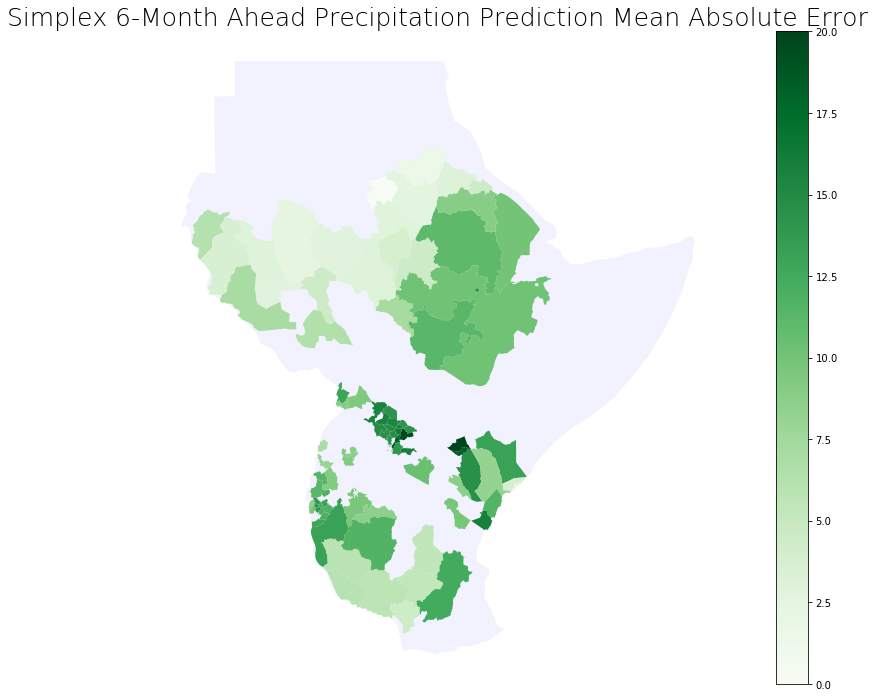

In [13]:
##change to Rho or RMSE

fig, ax = plt.subplots(1, figsize=(20, 12))
EastAfrica_basemap.plot(color = 'blue', ax = ax, alpha = 0.05)
merged_df.plot(column = variable, cmap='Greens', linewidth=0.8, ax=ax, edgecolor=None)
ax.axis('off')
ax.set_title('Simplex 6-Month Ahead Precipitation Prediction Mean Absolute Error', fontdict={'fontsize': '25', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

## 2. Generate Anomaly Rasters to remove Climatology

In [12]:
def stack_rasters(in_dir, keyword):
    
    '''
    This function creates a raster stack xarray DataArray given a specified variable keyword.
    Keywords = 'chirps', 'Tmax', 'ndvi', 'SM', 'pet', 'lst'
    
    '''
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains('.tif')
    files = files[tifs]
    
    stacked = []
    
    for filename in files: 
        if keyword in filename:
            file = xr.open_rasterio(in_dir+filename)
            stacked.append(file.sel(band=1))
            
    combined = xr.concat(stacked, dim = 'time')
  

    return combined.assign_coords(time=dekads)

In [376]:
stack_out = stack_rasters(savannas_vars_dir, 'lst')

In [378]:
#use this just for NDVI
# ds_ndvi = (stack_out-100)/100
# ds_anom = ds_ndvi - ds_ndvi.mean(dim = 'time')

#all other variables
ds_anom = stack_out - stack_out.mean(dim ='time')

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [379]:
def dataarray2tiff(dataarray, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D xarray DataArray into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile
        
    for i in np.arange(0,522, 1):
        data = np.array(dataarray[i])
       
        with rasterio.open(out_dir + out_name + str(np.array(dataarray[i].time))[:10] + '.tif', 'w', **profile) as dst:
            
            data = data.astype(np.float32)
            dst.write(data, indexes = 1)

In [380]:
dataarray2tiff(ds_anom, savannas_vars_dir, anomaly_lst + 'Savannas_Anomaly/', 'savannas_lst_anomaly_')

## 3. Pixelwise Prediction Skill Across Africa

In [13]:
def pixelwise_ts_table(in_dir):
    
    '''
    This function searches through the file directory and creates a dataframe of pixel values over time from rasters
    based on a given keyword describing the environmental variable of interest to generate a raster time series stack 
    
   In the output dataframe, columns are each pixel extracted from the raster (read squentially into a list)
   and rows are the same pixel over time (dekads going down)
    
    Args:
    - in_dir: path to the input directory
    -keyword: string that is unique to the environmental variable
        options: ['chirps', 'lst', 'ndvi', 'pet', 'SM', 'Tmax']
    '''
    
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains('.tif')
    files = files[tifs]#[0:522]
    
    
    pixelwise_TS = []
    
    for filename in tqdm(files): 
        
        open_file = xr.open_rasterio(in_dir+filename).sel(band=1)
        array = open_file.values
    
        pixel_list = array.ravel().tolist()
   
        pixelwise_TS.append(pixel_list)

    return pd.DataFrame(pixelwise_TS)

    

In [14]:
temp_crops_table = pixelwise_ts_table(anomaly_temp + 'Croplands_Anomaly/')
precip_crops_table = pixelwise_ts_table(anomaly_precip + 'Croplands_Anomaly/')
ndvi_crops_table = pixelwise_ts_table(anomaly_ndvi + 'Croplands_Anomaly/')

#sm_table = pixelwise_ts_table(croplands_vars_dir, 'SM')
#lst_table = pixelwise_ts_table(croplands_vars_dir, 'lst')
#pet_table = pixelwise_ts_table(croplands_vars_dir, 'pet')



100%|██████████| 522/522 [00:12<00:00, 42.50it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly/Croplands_Anomaly/'

In [18]:
temp_grass_table = pixelwise_ts_table(anomaly_temp + 'Grasslands_Anomaly/')
precip_grass_table = pixelwise_ts_table(anomaly_precip + 'Grasslands_Anomaly/')
ndvi_grass_table = pixelwise_ts_table(anomaly_ndvi + 'Grasslands_Anomaly/')

 29%|██▊       | 150/522 [00:02<00:07, 50.88it/s]


KeyboardInterrupt: 

In [385]:
temp_sav_table = pixelwise_ts_table(anomaly_temp + 'Savannas_Anomaly/')
precip_sav_table = pixelwise_ts_table(anomaly_precip + 'Savannas_Anomaly/')
ndvi_sav_table = pixelwise_ts_table(anomaly_ndvi + 'Savannas_Anomaly/')

100%|██████████| 522/522 [00:12<00:00, 40.17it/s]


In [386]:
temp_sav_table = pixelwise_ts_table(anomaly_temp + 'CropNatVeg_Anomaly/')
precip_sav_table = pixelwise_ts_table(anomaly_precip + 'CropNatVeg_Anomaly/')
ndvi_sav_table = pixelwise_ts_table(anomaly_ndvi + 'CropNatVeg_Anomaly/')

100%|██████████| 522/522 [00:11<00:00, 43.71it/s]


In [15]:
def pixelwise_simplex(table, train, test, ed, pi, rs_rows, rs_cols):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given a table of pixel values across time for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - in_dir: input directory 
    - file: filename (string)
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    ==
    - rs_rows: number of rows to reshape list into original raster size
    -rs_cols: number of columns to reshape list into original raster size
   
    '''

    simplex_out_df = []
    #table_chunk = table.loc[:100,500:510]
    
    for column in tqdm(table):
        #print(column)
        if table[column].isnull().values.any():
            #print('null')
            simplex_out_df.append(np.nan)
        else:
            #do simplex function on these columns
            #change dekads to just a time list
            interim_df = pd.DataFrame({'Time': list(range(0,522)), 'Data': table[column]}) #'Time': dekads
            simplex_result = Simplex(dataFrame = interim_df, lib = train, pred = test, E = ed, Tp = pi, 
                                     columns = 'Data', target = 'Data', showPlot = False)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            MAE = list(error.values())[0]
            RMSE = list(error.values())[1]
            rho = list(error.values())[2]
           
            simplex_out_df.append(rho) #adjust measure depending on output interest
            
    return(np.reshape(simplex_out_df, (rs_rows,rs_cols)))
            



In [16]:
ndvi_crops_africa_simplex = pixelwise_simplex(ndvi_crops_table, '1 100', '101 522', 2, 18, 800, 730)
temp_crops_africa_simplex = pixelwise_simplex(temp_crops_table, '1 100', '101 522', 2, 18, 800, 730)
precip_crops_africa_simplex = pixelwise_simplex(precip_crops_table, '1 100', '101 522', 2, 18, 800, 730)

ndvi_grass_africa_simplex = pixelwise_simplex(ndvi_grass_table, '1 100', '101 522', 2, 18, 800, 730)
temp_grass_africa_simplex = pixelwise_simplex(temp_grass_table, '1 100', '101 522', 2, 18, 800, 730)
precip_grass_africa_simplex = pixelwise_simplex(precip_grass_table, '1 100', '101 522', 2, 18, 800, 730)

ndvi_sav_africa_simplex = pixelwise_simplex(ndvi_sav_table, '1 100', '101 522', 2, 18, 800, 730)
temp_sav_africa_simplex = pixelwise_simplex(temp_sav_table, '1 100', '101 522', 2, 18, 800, 730)
precip_sav_africa_simplex = pixelwise_simplex(precip_sav_table, '1 100', '101 522', 2, 18, 800, 730)

NameError: name 'ndvi_crops_table' is not defined

In [2]:
ndvi_crops_africa_simplex

NameError: name 'ndvi_crops_africa_simplex' is not defined

In [19]:
def growing_pixelwise_simplex(table, ed, pi, rs_rows, rs_cols, train_start_date, train_end_date, test_start_date, test_end_date):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given a table of pixel values across the time of growing season given the months leading up to the rains
    for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: input table from pixelwise_ts_table result of each pixel's time series
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    -rs_cols: number of columns to reshape list into original raster size
   
    '''

    simplex_out_df = []
    #table_chunk = table.loc[:100,500:510]
    
    for column in tqdm(table):
        #print(column)
        if table[column].isnull().values.any():
            #print('null')
            simplex_out_df.append(np.nan)
        else:
            #do simplex function on these columns
            #change dekads to just a time list
            interim_df = pd.DataFrame({'Time': dekads, 'Data': table[column]}) #'Time': dekads
            train_season = interim_df[(interim_df['Time'].dt.month >= train_start_date) & (interim_df['Time'].dt.month <= train_end_date)]
            train_season.reset_index()
#             harvest_season = (interim_df['Time'] > train_start_date) & (interim_df['Time'] <= train_end_date)
#             harvest_df = interim_df.loc[harvest_season]
#             print(harvest_df.index[0])
#             print(harvest_df.index[-1])
            #train_rows = harvest_df.index
            test_season = interim_df[(interim_df['Time'].dt.month >= test_start_date) & (interim_df['Time'].dt.month <= test_end_date)]
           # print(rain_season.Time.head(20))
            test_season.reset_index()
#             rain_df = interim_df.loc[rain_season]
#             print(rain_df.index[0])
#             print(rain_df.index[-1])
#             test_rows = rain_df.index
            
            simplex_result = Simplex(dataFrame = interim_df, lib = str(train_season.index[0]) + ' ' + str(train_season.index[-1]), pred = str(test_season.index[0]) + ' ' + str(test_season.index[-1]), E = ed, Tp = pi, columns = 'Data', target = 'Data', showPlot = False)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            MAE = list(error.values())[0]
            RMSE = list(error.values())[1]
            rho = list(error.values())[2]
            
           
            simplex_out_df.append(rho) #adjust measure depending on output interest
            
    return(np.reshape(simplex_out_df, (rs_rows,rs_cols)))
            
            




In [22]:
ndvi_crops_deyr_rains = growing_pixelwise_simplex(ndvi_crops_table, 2, 18, 800, 730, 9, 11, 11, 12)#  '2015-09-01', '2015-11-01', '2015-11-1', '2016-01-01')


584000it [04:36, 2110.14it/s]                     


In [495]:
#temp_africa_simplex = pixelwise_simplex(temp_table, '1 100', '101 522', 2, 18, 800, 730)

NameError: name 'temp_table' is not defined

In [ ]:
#precip_africa_simplex = pixelwise_simplex(precip_table, '1 100', '101 522', 2, 18, 800, 730)

In [19]:
#temp_africa_simplex = pixelwise_simplex(temp_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_africa_simplex = pixelwise_simplex(precip_table, '1 100', '101 522', 2, 18, 800, 730)
# ndvi_africa_simplex = pixelwise_simplex(ndvi_table, '1 100', '101 522', 2, 18, 800, 730)

#sm_africa_simplex = pixelwise_simplex(sm_table, '1 100', '101 522', 2, 18, 800, 730)
#lst_africa_simplex = pixelwise_simplex(lst_table, '1 100', '101 522', 2, 18, 800, 730)
#pet_africa_simplex = pixelwise_simplex(pet_table, '1 100', '101 522', 2, 18, 800, 730)



584000it [01:22, 7039.39it/s]                      


convert array to raster to save out

In [24]:
def array2tiff(array, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D array into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile

    with rasterio.open(out_dir + out_name + '.tif', 'w', **profile) as dst:
        data = array
        data = data.astype(np.float32)
        #data[data<=0] = np.nan
        dst.write(data, indexes=1)
    


In [391]:
array2tiff(temp_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'temp_africa_simplex_crop')
array2tiff(precip_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'precip_africa_simplex_crop')
array2tiff(ndvi_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'ndvi_africa_simplex_crop')

array2tiff(temp_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'temp_africa_simplex_grass')
array2tiff(precip_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'precip_africa_simplex_grass')
array2tiff(ndvi_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'ndvi_africa_simplex_grass')

array2tiff(temp_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'temp_africa_simplex_sav')
array2tiff(precip_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'precip_africa_simplex_sav')
array2tiff(ndvi_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'ndvi_africa_simplex_sav')

In [392]:
#array2tiff(ndvi_africa_simplex, eMODIS_NDVI, Africa_simplex, 'ndvi_africa_simplex_all')

In [25]:
array2tiff(ndvi_crops_deyr_rains, croplands_vars_dir, Africa_simplex, 'ndvi_crops_deyr_rains')

Plot

In [51]:
def mask_raster_shp(shp, raster, out_name, in_dir, out_dir):
    
    '''
    This function masks a raster to the shape of a smaller shapefile and creates a new raster
    
    '''
    with fiona.open(shp, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(in_dir + raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(out_dir + out_name, "w", **out_meta) as dest:
        dest.write(out_image)

In [394]:
mask_raster_shp(ea_adminbds, 'temp_africa_simplex_crop.tif', 'temp_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_africa_simplex_crop.tif', 'precip_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_crop.tif', 'ndvi_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)

mask_raster_shp(ea_adminbds, 'temp_africa_simplex_grass.tif', 'temp_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_africa_simplex_grass.tif', 'precip_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_grass.tif', 'ndvi_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)

mask_raster_shp(ea_adminbds, 'temp_africa_simplex_sav.tif', 'temp_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_africa_simplex_sav.tif', 'precip_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_sav.tif', 'ndvi_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)



In [89]:
mask_raster_shp(Admin_boundaries+'Somalia.shp', 'ndvi_crops_deyr_rains.tif', 'ndvi_crops_somalia_deyr_rains.tif', Africa_simplex + 'Countries/Somalia/', Africa_simplex + 'Countries/Somalia/')


In [86]:
# def stack_by_lc(in_dir, file1, file2, file3, out_name):
    
#     '''
#     This function stacks rasters and can be used to pair results from different land covers but the same env variable together
#     '''
    
#     file_list = [in_dir + file1, in_dir + file2, in_dir + file3]

#     # Read metadata of first file
#     with rasterio.open(file_list[0]) as src0:
#         meta = src0.meta

#     # Update meta to reflect the number of layers
#     meta.update(count = len(file_list))

#     # Read each layer and write it to stack
#     with rasterio.open(in_dir + out_name, 'w', **meta) as dst:
#         for id, layer in enumerate(file_list, start=1):
#             with rasterio.open(layer) as src1:
#                 dst.write_band(id, src1.read(1))

Plot East Africa Simplex

In [32]:
temp_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_crop.tif')
precip_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_crop.tif')
ndvi_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_crop.tif')

temp_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_grass.tif')
precip_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_grass.tif')
ndvi_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_grass.tif')

temp_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_sav.tif')
precip_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_sav.tif')
ndvi_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_sav.tif')

In [ ]:
# fig, ax = plt.subplots(figsize=(15,15))

# show(ndvi_eastafrica_simplex_stack, ax=ax, cmap = 'RdPu')


# #zoom into East Africa
# EastAfrica_basemap.plot(ax=ax, facecolor='none', edgecolor='red')
# plt.axis([20, 55,-15,25])


In [ ]:
# raster_list = [temp_eastafrica_simplex_crop_tif, precip_eastafrica_simplex_crop_tif, ndvi_eastafrica_simplex_crop_tif]
# var_list = ['Temperature', 'Precipitation', 'NDVI']

# fig, axs = plt.subplots(1, 3, figsize = (30, 20))
# axs = axs.ravel()
# fig.subplots_adjust(wspace= 0.25, hspace = 0.35)
# fig = plt.gcf()
# for i, raster in enumerate(raster_list):
#     show(raster, ax=axs[i], cmap = 'Blues')
    
    
#     EastAfrica_basemap.plot(ax=axs[i], facecolor='none', edgecolor='darkblue', vmin = 0, vmax = 1)
    
#     axs[i].set_title(var_list[i], fontsize = 25)
    
# plt.savefig('/home/rgreen/ea_simplex_3panel.png', dpi = 300)

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 1))
# fig.subplots_adjust(bottom=0.5)
# cmap = mpl.cm.GnBu_r
# norm = mpl.colors.Normalize(vmin=0, vmax=1)

# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax, orientation='horizontal', label='Predictive Skill')  

# plt.savefig('/home/rgreen/colorbar_bugr', dpi = 300)

# 4. Embedding Dimension Spatial Sensitivity 
use Embed Dimension function

In [ ]:
embed_result = EmbedDimension(dataFrame = table, 
                                      lib = train, pred = test, columns = column, showPlot = False)
        max_embed = embed_result.iloc[embed_result['rho'].idxmax()][0]
        print(max_embed)

In [7]:
def pixelwise_embed_dimension(table, train, test, rs_rows, rs_cols):
    


    embed_max_df = []
    #table_chunk = table.loc[:100,500:510]
    
    for column in tqdm(table):
#         #print(column)
        if table[column].isnull().values.any():
            #print('null')
            embed_max_df.append(np.nan)
        else:
            interim_df = pd.DataFrame({'Time': list(range(0,522)), 'Data': table[column]}) #'Time': dekads
            embed_result = EmbedDimension(dataFrame = interim_df, 
                                      lib = train, pred = test, columns = 'Data', target = 'Data', showPlot = False)
            max_embed = embed_result.iloc[embed_result['rho'].idxmax()][0]
            
            #simplex_result = Simplex(dataFrame = interim_df, lib = train, pred = test, E = ed, Tp = pi, 
                                     #columns = 'Data', target = 'Data', showPlot = False)
#             error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
#             MAE = list(error.values())[0]
#             RMSE = list(error.values())[1]
#             rho = list(error.values())[2]
           
            embed_max_df.append(max_embed) #adjust measure depending on output interest
            
    return(np.reshape(embed_max_df, (rs_rows,rs_cols)))
            

In [ ]:
ndvi_africa_ed = pixelwise_embed_dimension(ndvi_table, '1 100', '101 522', 800, 730)